In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
# ==========================================================
# 📊 YOUTUBE POPULARITY PREDICTION (API DATASET MODEL)
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------------------------------------
# 1️⃣ Load the cleaned dataset
# ----------------------------------------------------------
path_api = "/content/drive/MyDrive/youtube-popularity-prediction/data/youtube_api_clean.csv"
df_api = pd.read_csv(path_api)

print(f"✅ Loaded dataset: {df_api.shape[0]} rows, {df_api.shape[1]} columns")

# ----------------------------------------------------------
# 2️⃣ Prepare numeric features & clean target
# ----------------------------------------------------------
def prepare_features(df, target_col="views"):
    df_num = df.select_dtypes(include=["number"]).copy()

    if target_col not in df_num.columns and target_col in df.columns:
        # Bring target into numeric copy
        df_num[target_col] = pd.to_numeric(df[target_col], errors="coerce")

    y = df_num[target_col].replace([np.inf, -np.inf], np.nan).dropna()
    X = df_num.loc[y.index].drop(columns=[target_col])
    return X, y

X_api, y_api = prepare_features(df_api, "views")
print(f"✅ Numeric features: {X_api.shape[1]} | Target samples: {len(y_api)}")

# ----------------------------------------------------------
# 3️⃣ Clean + log-transform the target variable
# ----------------------------------------------------------
# Drop invalid rows and apply log transform
y_api_clean = y_api.replace([np.inf, -np.inf], np.nan).dropna()
valid_idx = y_api_clean.index
X_api_clean = X_api.loc[valid_idx]

# Apply log1p safely
y_api_log = np.log1p(y_api_clean)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_api_clean, y_api_log, test_size=0.2, random_state=42)

print(f"✅ Clean target range: min={y_api_clean.min():,.0f}, max={y_api_clean.max():,.0f}")
print(f"✅ Train/Test split → {X_train.shape}, {X_test.shape}")

# ----------------------------------------------------------
# 4️⃣ Define models
# ----------------------------------------------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=6)

# ----------------------------------------------------------
# 5️⃣ Train & evaluate function
# ----------------------------------------------------------
def train_and_evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    preds_log = model.predict(X_test)

    # Replace NaNs or Infs before inverse transformation
    preds_log = np.nan_to_num(preds_log, nan=0.0, posinf=0.0, neginf=0.0)
    preds = np.expm1(preds_log)
    y_true = np.expm1(y_test)

    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    print(f"📊 {name} → RMSE: {rmse:,.0f}, R²: {r2:.3f}")
    return preds, rmse, r2

# ----------------------------------------------------------
# 6️⃣ Train models
# ----------------------------------------------------------
print("\n🚀 Training models...")
train_and_evaluate(rf, X_train, X_test, y_train, y_test, "Random Forest (API)")
train_and_evaluate(xgb, X_train, X_test, y_train, y_test, "XGBoost (API)")


✅ Loaded dataset: 2362 rows, 24 columns
✅ Numeric features: 15 | Target samples: 2362
✅ Clean target range: min=1,365, max=36,917,790
✅ Train/Test split → (1889, 15), (473, 15)

🚀 Training models...
📊 Random Forest (API) → RMSE: 301,415, R²: 0.900
📊 XGBoost (API) → RMSE: 752,151, R²: 0.378


(array([1.16884355e+04, 3.34389625e+05, 2.51140312e+04, 1.40720820e+07,
        2.63523875e+05, 1.23502969e+05, 3.55404395e+03, 2.64179375e+05,
        2.03136758e+04, 1.03684250e+05, 7.47122422e+04, 6.80943945e+03,
        1.60616318e+04, 2.81809531e+05, 6.85184141e+04, 1.71469906e+05,
        8.61189844e+04, 1.18287125e+05, 5.40628281e+04, 1.13097883e+05,
        1.28795288e+06, 2.63405449e+04, 1.27486734e+05, 1.36383691e+04,
        5.09954812e+05, 2.11227234e+05, 6.21268789e+04, 6.66866250e+04,
        1.48436594e+05, 2.81747188e+05, 7.12308500e+05, 1.42200703e+04,
        3.40898008e+04, 3.82549883e+04, 5.43390117e+04, 4.18650703e+04,
        2.93739922e+04, 1.49886562e+05, 6.28277148e+03, 3.69179922e+04,
        3.37518711e+04, 5.19579590e+03, 7.12454625e+05, 2.03776133e+04,
        2.26974570e+04, 3.06066594e+05, 2.96436094e+05, 1.46899609e+05,
        4.25580391e+04, 7.21397734e+04, 1.43973828e+05, 3.29562500e+04,
        1.64464812e+05, 1.03697703e+05, 1.00565719e+05, 1.366467

In [11]:
# ==========================================================
# 📊 YOUTUBE POPULARITY PREDICTION (SCRAPED DATASET MODEL)
# ==========================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ----------------------------------------------------------
# 1️⃣ Load cleaned scraped dataset
# ----------------------------------------------------------
path_scraped = "/content/drive/MyDrive/youtube-popularity-prediction/data/youtube_scraped_clean.csv"
df_scraped = pd.read_csv(path_scraped)

print(f"✅ Loaded scraped dataset: {df_scraped.shape[0]} rows, {df_scraped.shape[1]} columns")

# ----------------------------------------------------------
# 2️⃣ Prepare numeric features
# ----------------------------------------------------------
def prepare_features(df, target_col="views"):
    df_num = df.select_dtypes(include=["number"]).copy()

    if target_col not in df_num.columns and target_col in df.columns:
        df_num[target_col] = pd.to_numeric(df[target_col], errors="coerce")

    y = df_num[target_col].replace([np.inf, -np.inf], np.nan).dropna()
    X = df_num.loc[y.index].drop(columns=[target_col])
    return X, y

X_scraped, y_scraped = prepare_features(df_scraped, "views")
print(f"✅ Numeric features: {X_scraped.shape[1]} | Target samples: {len(y_scraped)}")

# ----------------------------------------------------------
# 3️⃣ Clean + log-transform the target
# ----------------------------------------------------------
y_scraped_clean = y_scraped.replace([np.inf, -np.inf], np.nan).dropna()
valid_idx = y_scraped_clean.index
X_scraped_clean = X_scraped.loc[valid_idx]

y_scraped_log = np.log1p(y_scraped_clean)

X_train, X_test, y_train, y_test = train_test_split(X_scraped_clean, y_scraped_log, test_size=0.2, random_state=42)

print(f"✅ Target range: min={y_scraped_clean.min():,.0f}, max={y_scraped_clean.max():,.0f}")
print(f"✅ Train/Test split → {X_train.shape}, {X_test.shape}")

# ----------------------------------------------------------
# 4️⃣ Define models
# ----------------------------------------------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=6)

# ----------------------------------------------------------
# 5️⃣ Train & evaluate function (same as before)
# ----------------------------------------------------------
def train_and_evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    preds_log = model.predict(X_test)
    preds_log = np.nan_to_num(preds_log, nan=0.0, posinf=0.0, neginf=0.0)
    preds = np.expm1(preds_log)
    y_true = np.expm1(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, preds))
    r2 = r2_score(y_true, preds)
    print(f"📊 {name} → RMSE: {rmse:,.0f}, R²: {r2:.3f}")
    return preds, rmse, r2

# ----------------------------------------------------------
# 6️⃣ Train models
# ----------------------------------------------------------
print("\n🚀 Training models on scraped data...")
train_and_evaluate(rf, X_train, X_test, y_train, y_test, "Random Forest (Scraped)")
train_and_evaluate(xgb, X_train, X_test, y_train, y_test, "XGBoost (Scraped)")


✅ Loaded scraped dataset: 60 rows, 15 columns
✅ Numeric features: 7 | Target samples: 60
✅ Target range: min=4,245, max=6,587,877,597
✅ Train/Test split → (48, 7), (12, 7)

🚀 Training models on scraped data...
📊 Random Forest (Scraped) → RMSE: 326,923,244, R²: 0.957
📊 XGBoost (Scraped) → RMSE: 269,657,645, R²: 0.971


(array([2.2114125e+05, 3.0269041e+05, 6.5558298e+09, 3.7200700e+05,
        2.5895852e+05, 2.8712718e+06, 8.2409677e+08, 2.8712718e+06,
        2.2115412e+05, 1.8949804e+06, 5.9799780e+06, 2.8055025e+06],
       dtype=float32),
 np.float64(269657644.71570295),
 0.9705798079923785)

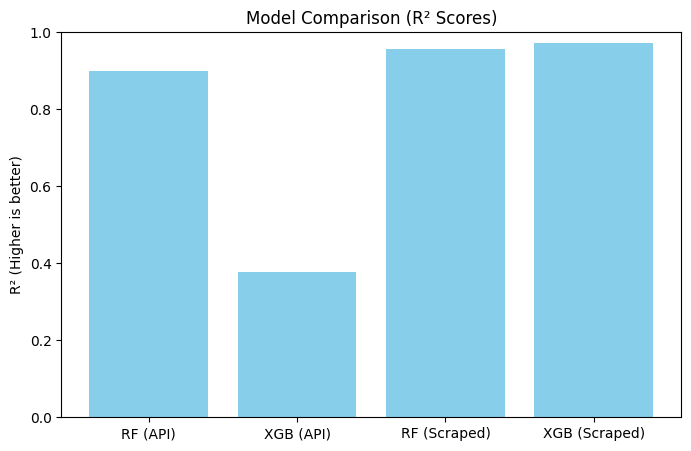

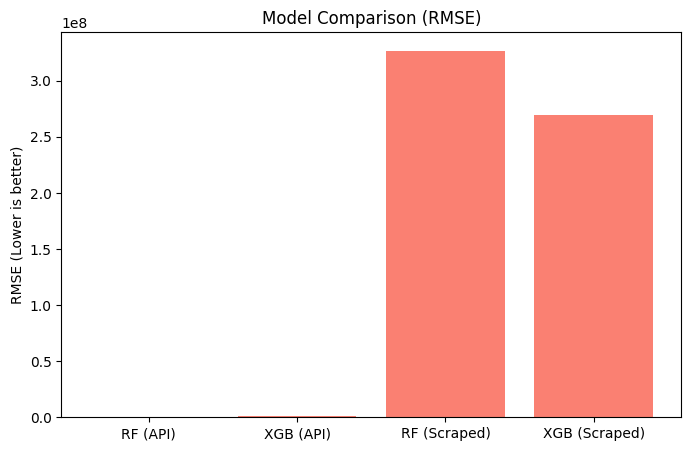

In [12]:
import matplotlib.pyplot as plt

# Metrics summary
models = ["RF (API)", "XGB (API)", "RF (Scraped)", "XGB (Scraped)"]
r2_scores = [0.900, 0.378, 0.957, 0.971]
rmse_scores = [301415, 752151, 326923244, 269657645]

fig, ax1 = plt.subplots(figsize=(8, 5))

# R² plot
ax1.bar(models, r2_scores, color='skyblue')
ax1.set_title("Model Comparison (R² Scores)")
ax1.set_ylabel("R² (Higher is better)")
ax1.set_ylim(0, 1)
plt.show()

# RMSE plot
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_scores, color='salmon')
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE (Lower is better)")
plt.show()


In [2]:
!ls -lh /content/drive/MyDrive/youtube-popularity-prediction/data


ls: cannot access '/content/drive/MyDrive/youtube-popularity-prediction/data': No such file or directory
